In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import packages

In [85]:
!pip install librosa

In [86]:
!pip3 install catboost

In [112]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns

plt.rcParams['axes.facecolor'] = 'none'
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
# import catboost as cb
from catboost import CatBoostClassifier as CD

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

# Audio exploration

In [88]:
path = '/content/drive/MyDrive/Colab Notebooks/music genre classification/Data'
print(list(os.listdir(f'{path}/genres_original/')))

['pop', 'disco', 'rock', 'country', 'blues', 'metal', 'reggae', 'jazz', 'classical', 'hiphop']


Now we are going to make a function which will plot waveplot

In [89]:
def plot_sound(path):
    plt.figure(figsize=(14, 5))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveplot(x, sr=sr)
    
    return x

Take one audio from blues, rock and pop songs

length (661794,), sample-rate 22050


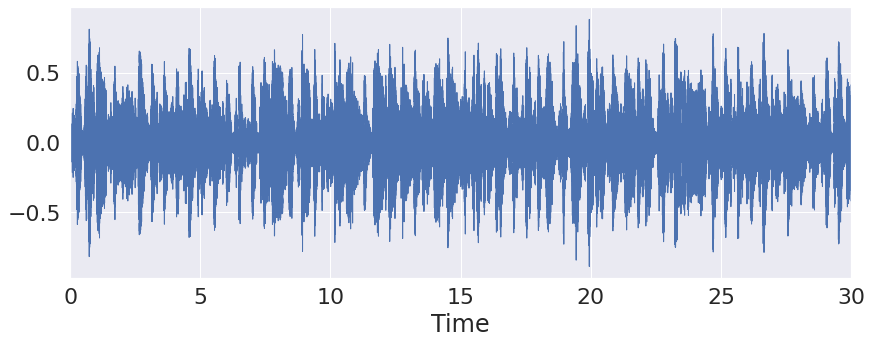

In [90]:
blues_path = path + '/genres_original/blues/blues.00000.wav'
blues_audio = plot_sound(blues_path)
ipd.Audio(blues_path)

length (661794,), sample-rate 22050


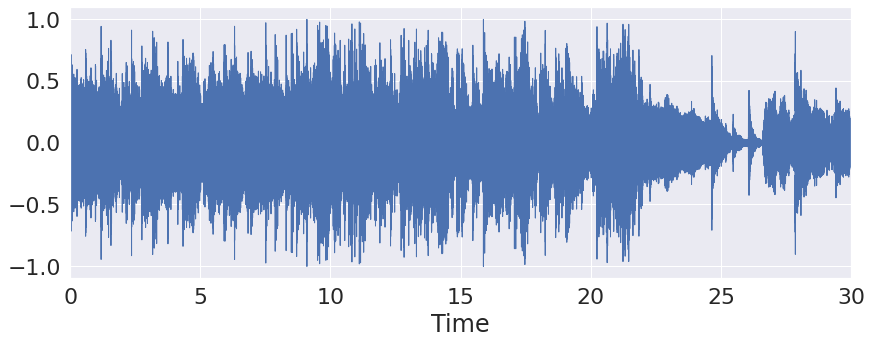

In [91]:
rock_path = path + '/genres_original/rock/rock.00001.wav'
rock_audio = plot_sound(rock_path)
ipd.Audio(rock_path)

In [92]:
wave_sample_rate, wave_audio = wav.read(rock_path)
print(wave_sample_rate)
print(wave_audio)


22050
[11875 21282 20701 ...  1421  1826  1868]


**Plot Spectrogram**

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

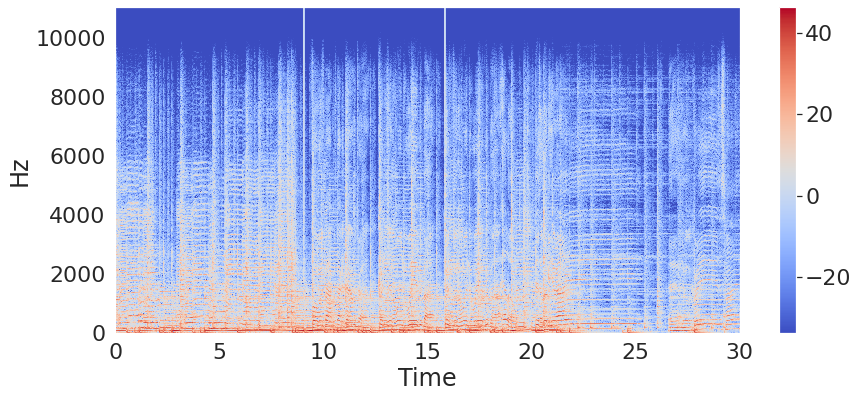

In [93]:
x, sr = librosa.load(rock_path)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.

In [94]:
df = pd.read_csv(path + '/features_3_sec.csv')
print(df.columns)
print(df.shape)
print(df.info())
df.head()

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

Let's check whther our dataset is balanced or not

In [95]:
df['label'].value_counts()

jazz         1000
metal        1000
reggae       1000
pop          1000
blues        1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: label, dtype: int64

So our dataset is balanced dataset

**Correlation Heatmap for feature means**

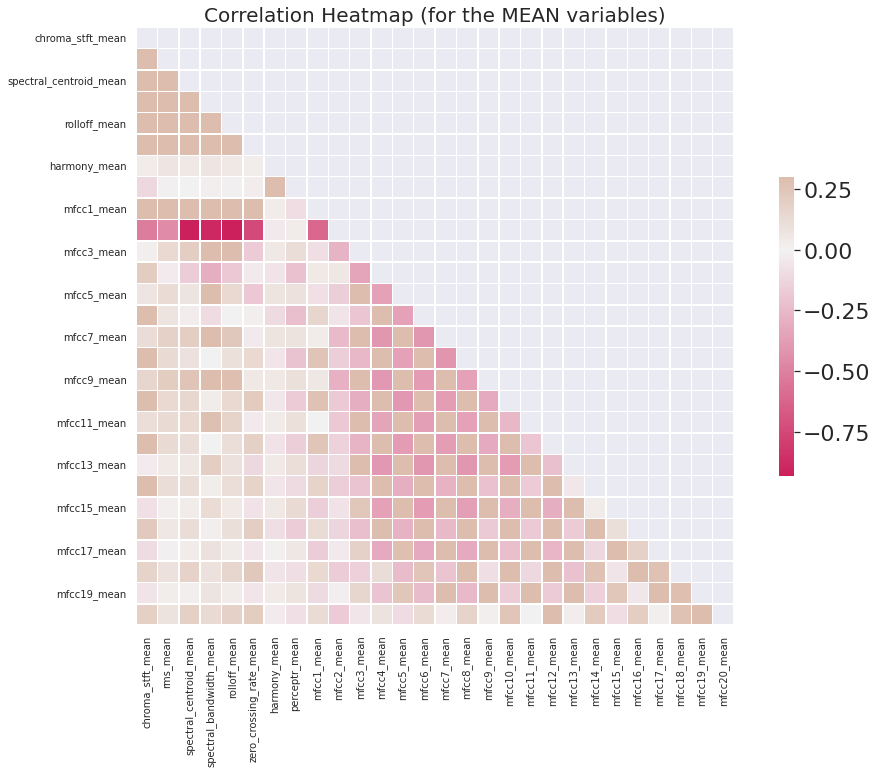

In [96]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

# Data Preprocessing

In [97]:
#Let's convert the label values into integers
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [98]:
X = df.drop(['label','filename'],axis=1)
y = df['label'] 

#We are going to normalize our data
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

# Model Training

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6993, 58), (2997, 58), (6993,), (2997,))

In [100]:
#confusion matrix

def conf_matrix(pred,classfier):
  predictions = pred
  y_pred = np.array(predictions)
  cm = confusion_matrix(y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['pop', 'disco', 'rock', 'country', 'blues', 'metal', 'reggae', 'jazz', 'classical', 'hiphop'], 
                       columns = ['pop', 'disco', 'rock', 'country', 'blues', 'metal', 'reggae', 'jazz', 'classical', 'hiphop'])
  plt.figure(figsize=(11,8))
  sns.set(font_scale=2)
  sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.title('\n'+classfier+' Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.show()
  plt.close()

In [101]:
#report generation

def report_generate(pred,classfier):
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred = pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'pop','1':'disco','2':'rock','3':'country',
                                '4': 'blues','5':'metal','6':'reggae',
                                '7': 'jazz','8':'classical','9':'hiphop',})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  
  plt = report.plot(kind='bar',figsize=(20,8))
  plot=plt.tick_params(rotation=40)
  return plot,report

In [102]:
sns.set_style("whitegrid")
def model_assess(model, title = 'Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    conf_matrix(preds, title)
    report = report_generate(preds,title)
    return report[1]



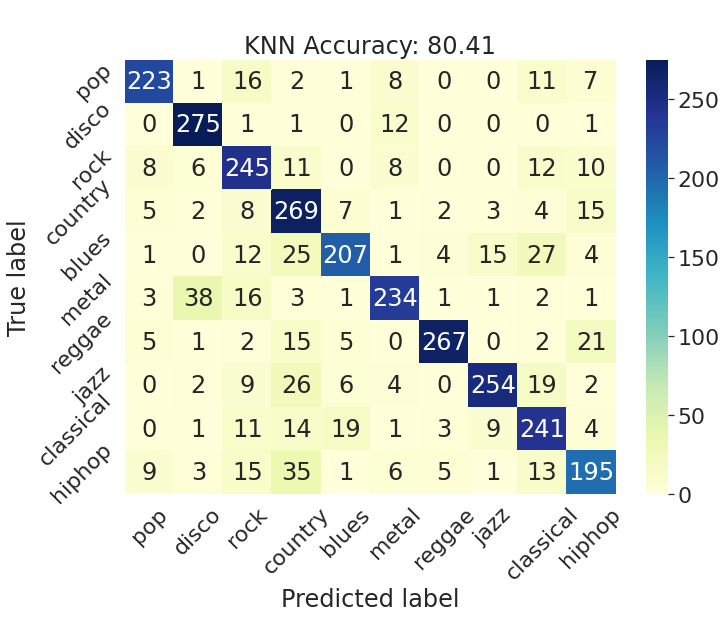

precision  recall  f1-score
pop               87.80   82.90     85.28
disco             83.59   94.83     88.85
rock              73.13   81.67     77.17
country           67.08   85.13     75.03
blues             83.81   69.93     76.24
metal             85.09   78.00     81.39
reggae            94.68   83.96     89.00
jazz              89.75   78.88     83.97
classical         72.81   79.54     76.03
hiphop            75.00   68.90     71.82
accuracy          80.41   80.41     80.41
macro avg         81.27   80.37     80.48
weighted avg      81.29   80.41     80.50

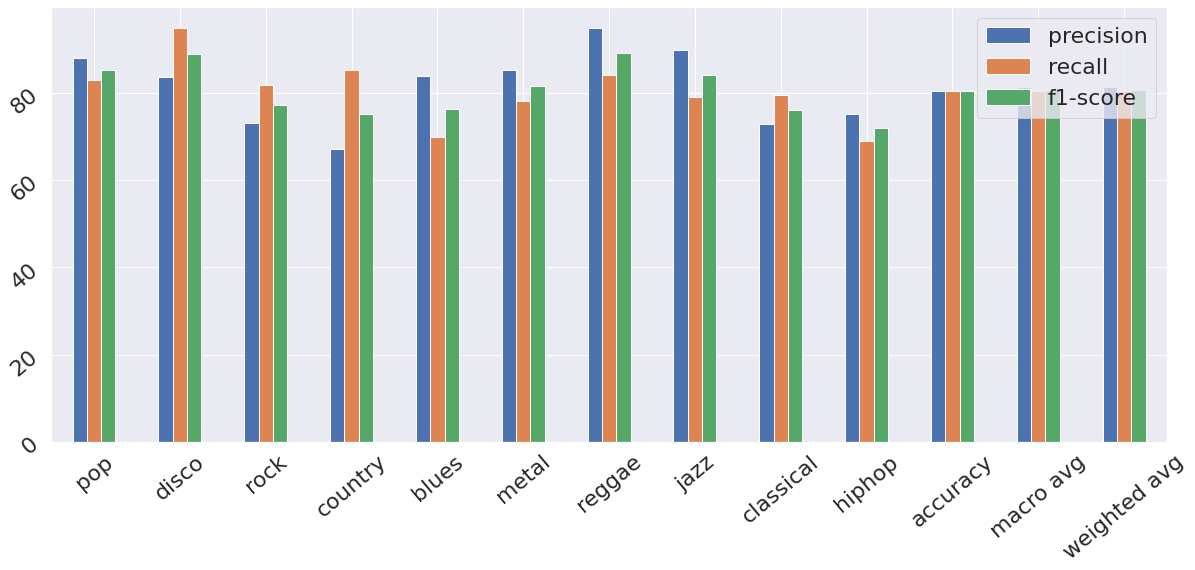

In [103]:
# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, 'KNN')


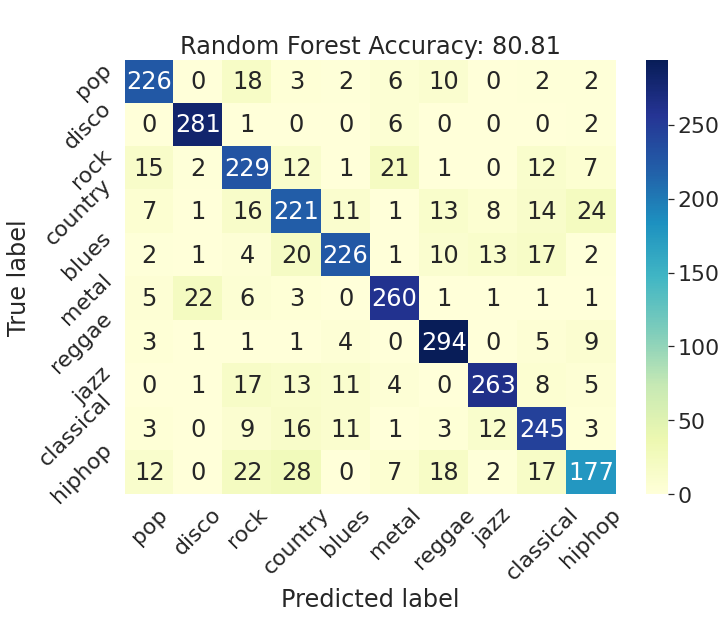

precision  recall  f1-score
pop               82.78   84.01     83.39
disco             90.94   96.90     93.82
rock              70.90   76.33     73.52
country           69.72   69.94     69.83
blues             84.96   76.35     80.43
metal             84.69   86.67     85.67
reggae            84.00   92.45     88.02
jazz              87.96   81.68     84.70
classical         76.32   80.86     78.53
hiphop            76.29   62.54     68.74
accuracy          80.81   80.81     80.81
macro avg         80.86   80.77     80.66
weighted avg      80.83   80.81     80.67

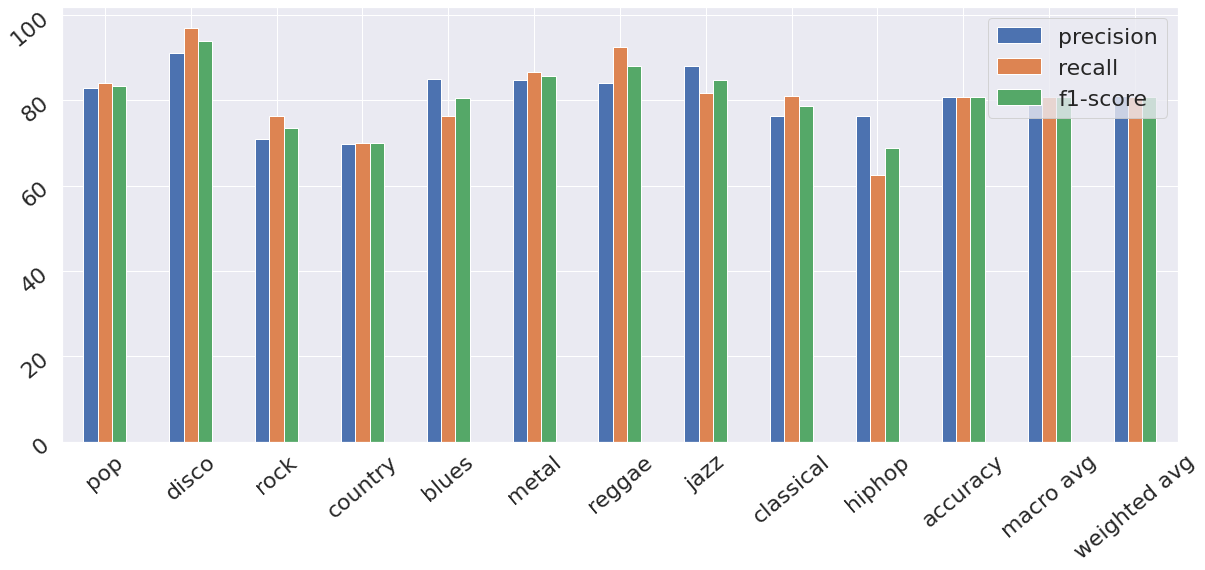

In [104]:
# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

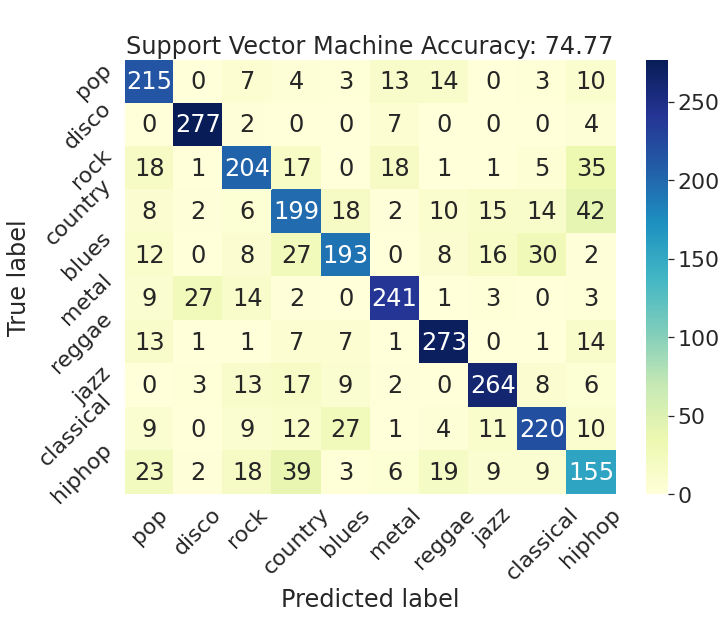

precision  recall  f1-score
pop               70.03   79.93     74.65
disco             88.50   95.52     91.87
rock              72.34   68.00     70.10
country           61.42   62.97     62.19
blues             74.23   65.20     69.42
metal             82.82   80.33     81.56
reggae            82.73   85.85     84.26
jazz              82.76   81.99     82.37
classical         75.86   72.61     74.20
hiphop            55.16   54.77     54.96
accuracy          74.77   74.77     74.77
macro avg         74.58   74.72     74.56
weighted avg      74.74   74.77     74.67

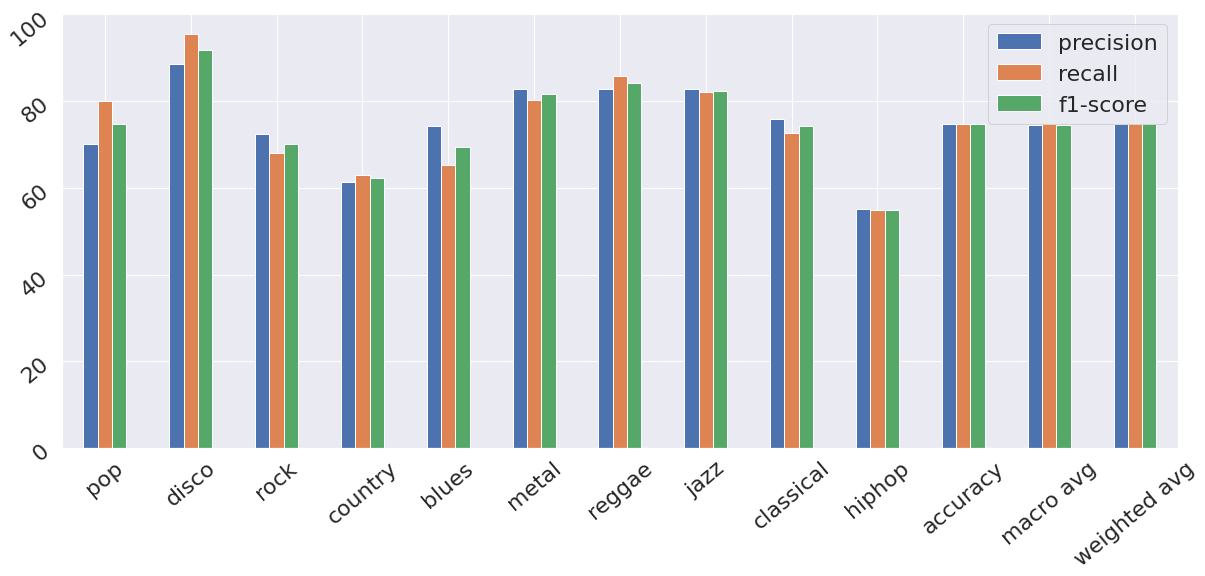

In [105]:
# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

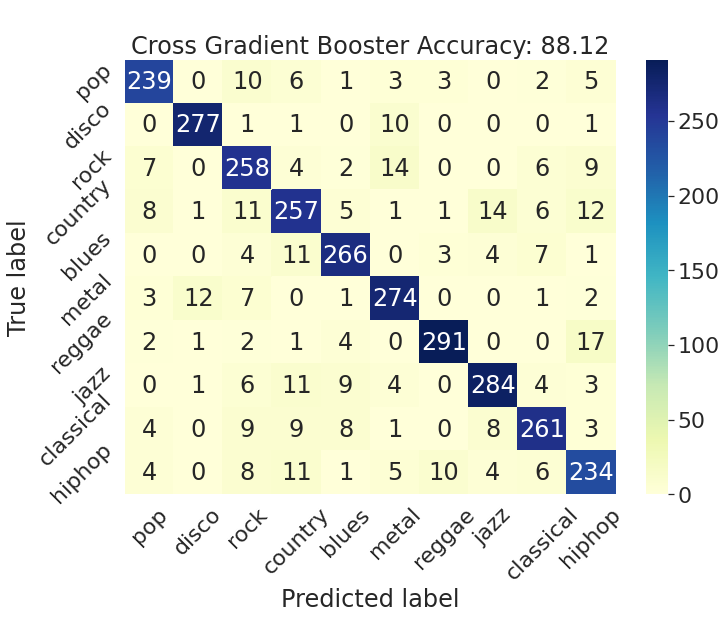

precision  recall  f1-score
pop               89.51   88.85     89.18
disco             94.86   95.52     95.19
rock              81.65   86.00     83.77
country           82.64   81.33     81.98
blues             89.56   89.86     89.71
metal             87.82   91.33     89.54
reggae            94.48   91.51     92.97
jazz              90.45   88.20     89.31
classical         89.08   86.14     87.58
hiphop            81.53   82.69     82.11
accuracy          88.12   88.12     88.12
macro avg         88.16   88.14     88.13
weighted avg      88.18   88.12     88.14

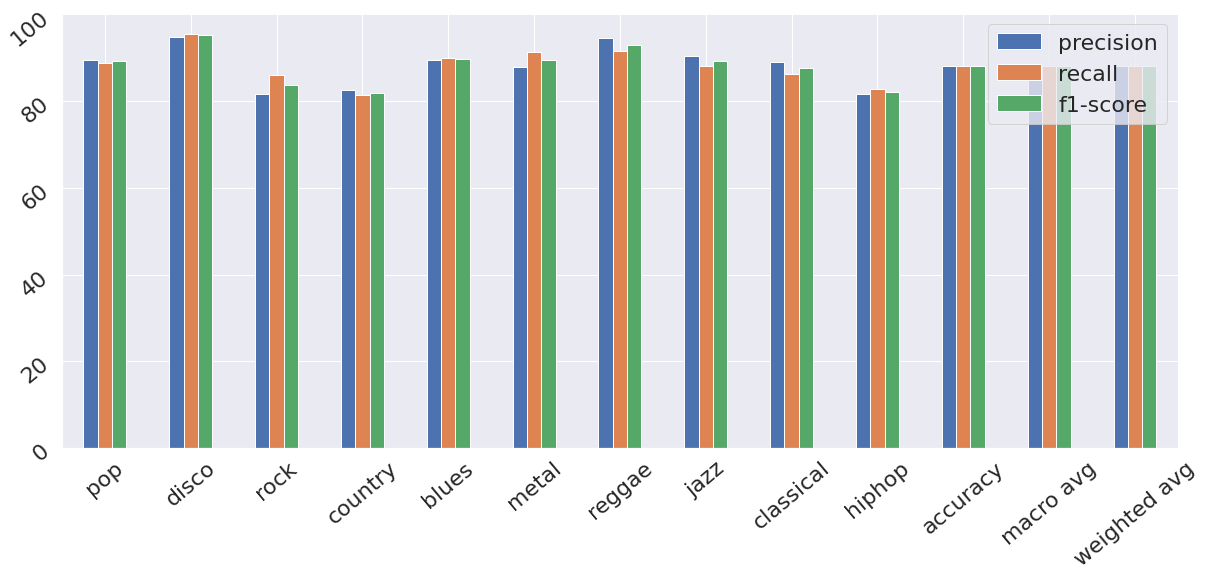

In [106]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

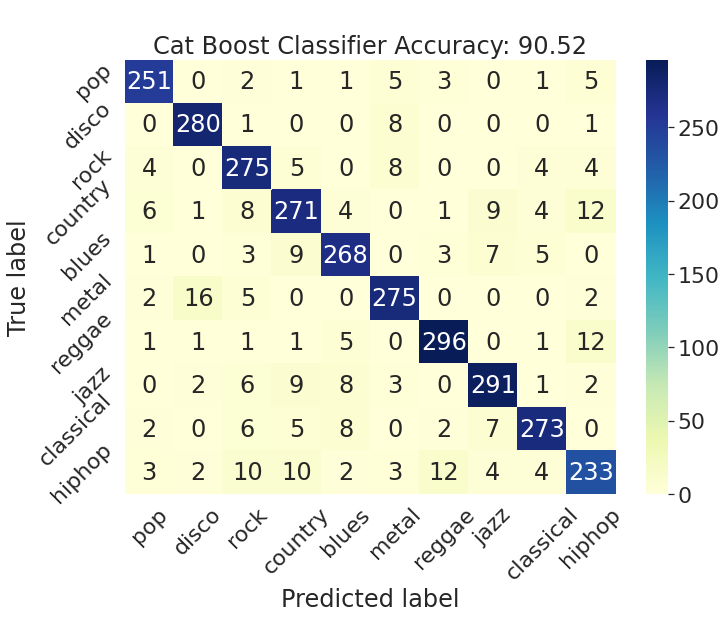

precision  recall  f1-score
pop               92.96   93.31     93.14
disco             92.72   96.55     94.59
rock              86.75   91.67     89.14
country           87.14   85.76     86.44
blues             90.54   90.54     90.54
metal             91.06   91.67     91.36
reggae            93.38   93.08     93.23
jazz              91.51   90.37     90.94
classical         93.17   90.10     91.61
hiphop            85.98   82.33     84.12
accuracy          90.52   90.52     90.52
macro avg         90.52   90.54     90.51
weighted avg      90.52   90.52     90.51

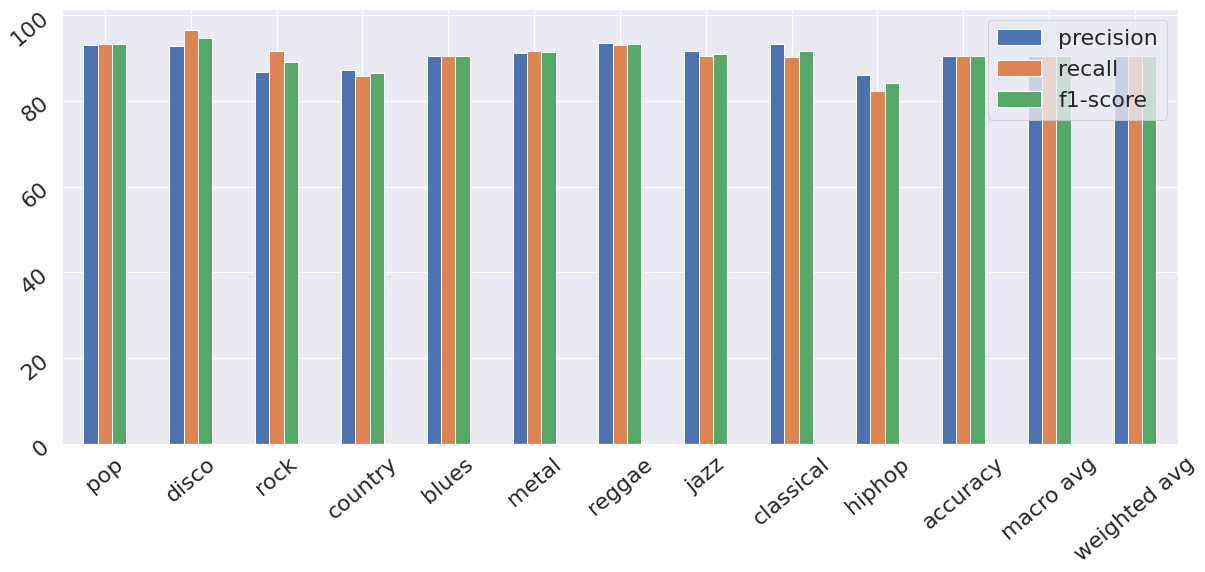

In [107]:

# catboost
cbc = CD(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
model_assess(cbc,"Cat Boost Classifier")

In [108]:
compare = pd.read_csv(path + "/results.csv")
compare

metrics    KNN     RF    SVM    XGB    CAT
0   accuracy  80.41  80.81  74.77  88.12  90.52
1  precision  81.29  80.83  74.74  88.18  90.52
2     recall  80.41  80.81  74.77  88.12  90.52
3   f1 score  80.50  80.67  74.67  88.14  90.51

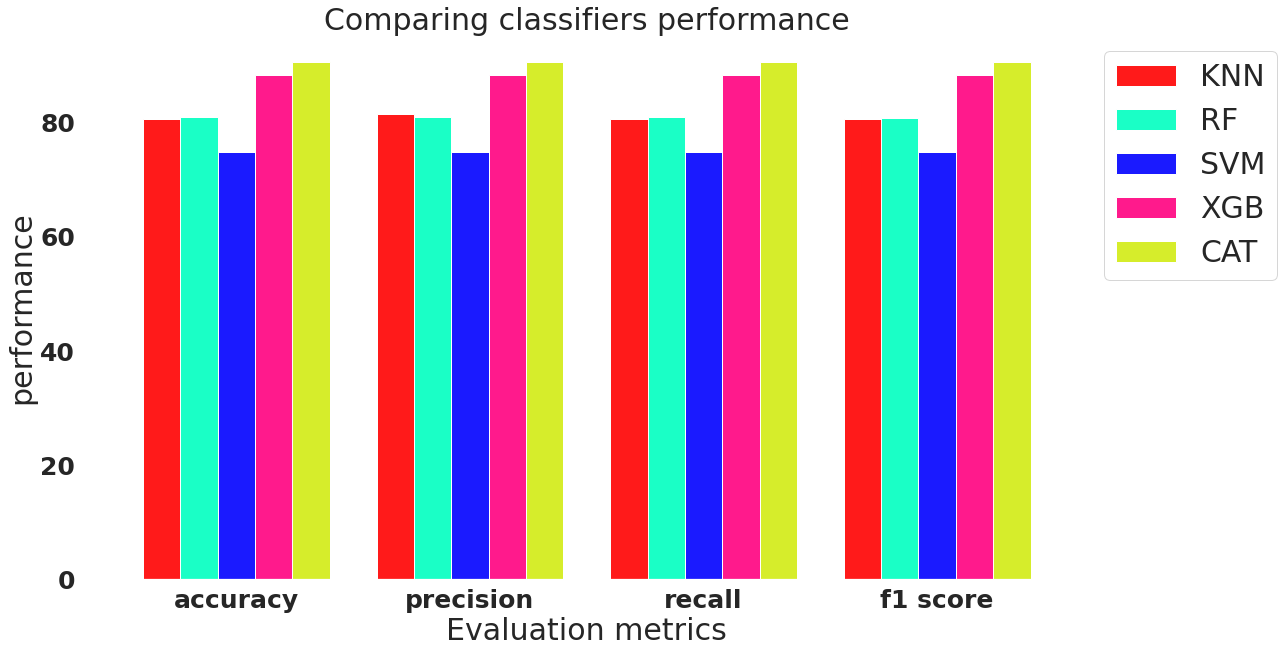

In [114]:

compare.reset_index().plot(
    x='metrics', y=["KNN", "RF", "SVM", "XGB","CAT"], kind="bar",figsize=(18,10), width = 0.8,color=['#ff1a1a','#1affc6','#1a1aff', '#ff1a8c', '#d6ed2b' ])
plt.xlabel('Evaluation metrics',fontsize=30)
plt.ylabel('performance',fontsize=30)
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=25)
plt.tick_params(rotation=0,axis='x', labelsize=25)
plt.title('Comparing classifiers performance',fontsize=30)
plt.legend( loc=2,bbox_to_anchor = (1,1), prop={'size': 30})
